#  Image Stiching using Harris Corner Detection

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

def gaussian_kernel(size=3, sigma=1):
    kernel1D = np.linspace(-(size // 2), size // 2, size)
    kernel2D = np.outer(np.exp(-0.5 * (kernel1D / sigma) ** 2), np.exp(-0.5 * (kernel1D / sigma) ** 2))
    kernel2D /= 2 * np.pi * sigma * sigma
    return kernel2D

def apply_sobel_operator(image):
    # Applying Sobel operator to compute gradients in both x and y directions
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    Ix = convolve2d(image, Kx, boundary='symm', mode='same')
    Iy = convolve2d(image, Ky, boundary='symm', mode='same')
    return Ix, Iy

def detect_harris_corners(image, k=0.04, threshold_ratio=0.01):
    # Loading the image and applying Sobel operator for to compute gradient
    #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    Ix, Iy = apply_sobel_operator(image)

    Ixx = convolve2d(Ix**2, gaussian_kernel(), boundary='symm', mode='same')
    Iyy = convolve2d(Iy**2, gaussian_kernel(), boundary='symm', mode='same')
    Ixy = convolve2d(Ix*Iy, gaussian_kernel(), boundary='symm', mode='same')

    # Computing Harris response
    detM = Ixx * Iyy - Ixy ** 2
    traceM = Ixx + Iyy
    R = detM - k * traceM ** 2

    # Thresholding to find corners
    corners = np.argwhere(R > np.max(R) * threshold_ratio)
    return corners


In [2]:

import numpy as np
import cv2
from google.colab.patches import cv2_imshow

class features:
    def generate_homography(src_img, dst_img, opt='BF', ratio=0.75, ransacRep=5.0):
        """
        Generates a homography matrix to align two images.

        Args:
        - src_img: Source image
        - dst_img: Destination image
        - opt: Feature detector type ('SIFT' or 'BF' for Brute Force)
        - ratio: Lowe's ratio for feature matching
        - ransacRep: RANSAC reprojection threshold

        Returns:
        - H: Homography matrix
        - matchesMask: Mask indicating the matched keypoints
        - src_keypoints: Keypoints of the source image
        - dst_keypoints: Keypoints of the destination image
        """
        def find_and_describe_features(image):
            """
            Find keypoints using Harris corners and describe them using ORB descriptors.
            """
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Detect Harris corners
            corners = detect_harris_corners(gray_image)

            # Determine threshold for corners
            keypoints = [cv2.KeyPoint(float(x), float(y), 5) for y, x in corners]  # setting size to 5, which is more typical
            if not keypoints:
                return [], np.array([])

            # Create ORB descriptor to describe keypoints
            orb = cv2.ORB_create()
            keypoints, features = orb.compute(gray_image, keypoints)
            features = np.float32(features)
            plot_harris_points(gray_image, keypoints)

            return keypoints, features


        import matplotlib.pyplot as plt

        def plot_harris_points(image, keypoints):
            """
            Plot the Harris corner points on the image using OpenCV.
            """
            img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 0, 255),
                                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cv2_imshow( img_with_keypoints)
            cv2.waitKey(0)
            cv2.destroyAllWindows()



        def match_features(featuresA, featuresB):
            # Function to match features between two sets of features
            featureMatcher = cv2.DescriptorMatcher_create("BruteForce")

            matches = featureMatcher.knnMatch(featuresA, featuresB, k=2)
            good = [m for m, n in matches if m.distance < ratio * n.distance]

            if len(good) > 4:
                return good
            else:
                raise Exception("Not enough matches")

        # Find and describe features in source and destination images
        src_keypoints, src_features = find_and_describe_features(src_img)
        dst_keypoints, dst_features = find_and_describe_features(dst_img)

        # Match features between the source and destination images
        good_matches = match_features(src_features, dst_features)

        # Get matched keypoints
        src_points = np.float32([src_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([dst_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography matrix using RANSAC
        H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)

        # Generate mask indicating the matched keypoints
        matchesMask = mask.ravel().tolist()
        #plot_matches(image_1, k1, image_2, k2, good_matches)

        return H, matchesMask, src_keypoints, dst_keypoints, good_matches


In [3]:
class ImageStitcher:
    def blend_and_create_panorama(resized_dst_img, warped_src_img, dst_width, stitching_side, display_step=False):
        """
        Blends two images to create a panorama.

        Args:
        - resized_dst_img: Resized destination image
        - warped_src_img: Warped source image
        - dst_width: Width of the destination image
        - stitching_side: Side on which the images are being stitched ('left' or 'right')
        - display_step: Whether to display intermediate blending steps

        Returns:
        - panorama: Blended panorama image
        - left_side: Left side image (for display)
        - right_side: Right side image (for display)
        """
        def create_blending_mask(height_input, width_input, barrier_input, smoothing_window_input, left_biased_input=True):
            # Function to create blending mask
            assert barrier_input < width_input
            mask_output = np.zeros((height_input, width_input))

            offset_value = int(smoothing_window_input / 2)
            left_range_output = slice(barrier_input - offset_value, barrier_input + offset_value + 1)
            right_range_output = slice(barrier_input + offset_value + 1, None) if not left_biased_input else slice(None, barrier_input - offset_value)

            if left_biased_input:
                mask_output[:, left_range_output] = np.tile(np.linspace(1, 0, 2 * offset_value + 1).T, (height_input, 1))
            else:
                mask_output[:, left_range_output] = np.tile(np.linspace(0, 1, 2 * offset_value + 1).T, (height_input, 1))

            mask_output[:, right_range_output] = 1

            return cv2.merge([mask_output, mask_output, mask_output])

        h, w, _ = resized_dst_img.shape
        smoothing_window_size = int(dst_width / 8)
        barrier_position = dst_width - int(smoothing_window_size / 2)
        blending_mask_left = create_blending_mask(h, w, barrier_position, smoothing_window_size, True)
        blending_mask_right = create_blending_mask(h, w, barrier_position, smoothing_window_size, False)

        if stitching_side == 'left':
            resized_dst_img, warped_src_img = cv2.flip(resized_dst_img, 1), cv2.flip(warped_src_img, 1)
            resized_dst_img, warped_src_img = resized_dst_img * blending_mask_left, warped_src_img * blending_mask_right
            panorama = cv2.flip(warped_src_img + resized_dst_img, 1)
            left_side, right_side = cv2.flip(warped_src_img, 1), cv2.flip(resized_dst_img, 1) if display_step else (None, None)
        else:
            resized_dst_img, warped_src_img = resized_dst_img * blending_mask_left, warped_src_img * blending_mask_right
            panorama = warped_src_img + resized_dst_img
            left_side, right_side = resized_dst_img, warped_src_img if display_step else (None, None)

        return panorama, warped_src_img + resized_dst_img if display_step else None, left_side, right_side

    def warp_blend_and_crop_images(source_image, destination_image, show_step=False):
        """
        Warps, blends, and crops two images to create a panorama.

        Args:
        - source_image: Source image
        - destination_image: Destination image
        - show_step: Whether to display intermediate blending steps

        Returns:
        - panorama: Blended and cropped panorama image
        - non_blend: Blended image without cropping (for display)
        - left_side: Left side image (for display)
        - right_side: Right side image (for display)
        - src_keypoints: Keypoints of the source image
        - dst_keypoints: Keypoints of the destination image
        """
        try:
            # Generate Homography matrix
            H, _, src_keypoints, dst_keypoints, good_matches = features.generate_homography(source_image, destination_image)

            # Get height and width of two images
            height_src, width_src = source_image.shape[:2]
            height_dst, width_dst = destination_image.shape[:2]

            # Extract corners of two images: top-left, bottom-left, bottom-right, top-right
            pts1 = np.float32([[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]).reshape(-1, 1, 2)
            pts2 = np.float32([[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]).reshape(-1, 1, 2)

            # Apply homography to corners of source_image
            pts1_transformed = cv2.perspectiveTransform(pts1, H)
            corners = np.concatenate((pts1_transformed, pts2), axis=0)

            # Find max min of x,y coordinate
            [xmin, ymin] = np.int64(corners.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int64(corners.max(axis=0).ravel() + 0.5)
            t = [-xmin, -ymin]

            # Determine side for merging images
            if corners[0][0][0] < 0:
                side = 'left'
                width_panorama = width_dst + t[0]
            else:
                width_panorama = int(pts1_transformed[3][0][0])
                side = 'right'

            height_panorama = ymax - ymin

            # Translation
            H_translated = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
            warped_source_image = cv2.warpPerspective(source_image, H_translated.dot(H), (width_panorama, height_panorama))

            # Generating size of resized_destination_image which has the same size as warped_source_image
            resized_destination_image = np.zeros((height_panorama, width_panorama, 3))
            resized_destination_image[t[1]:height_src + t[1], t[0]:width_dst + t[0] if side == 'left' else width_dst] = destination_image

            # Blending panorama
            panorama, non_blend, left_side, right_side = ImageStitcher.blend_and_create_panorama(resized_destination_image, warped_source_image, width_dst, side, show_step)


            # Cropping black region
            [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
            t = [-xmin, -ymin]

            # Determine if the warped image is merged to the left or right side of the destination image
            if corners[0][0][0] < 0:
                n = int(abs(-corners[1][0][0] + corners[0][0][0]))
                panorama = panorama[t[1]:height_dst + t[1], n:, :]
            else:
                if corners[2][0][0] < corners[3][0][0]:
                    panorama = panorama[t[1]:height_dst + t[1], 0:int(corners[2][0][0]), :]
                else:
                    panorama = panorama[t[1]:height_dst + t[1], 0:int(corners[3][0][0]), :]

            return panorama, non_blend, left_side, right_side, src_keypoints, dst_keypoints, good_matches
        except Exception as e:
            raise Exception("Error in stitching and cropping images: {}".format(e))


In [7]:
#Read Images
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_1 = cv2.imread('Image_1.jpeg')
image_2 = cv2.imread('Image_2.jpeg')
pano_ori = cv2.imread('GT.jpeg')

#image_1 = cv2.resize(image_1, (200, 200), interpolation=cv2.INTER_AREA)
#image_2 = cv2.resize(image_2, (200, 200), interpolation=cv2.INTER_AREA)

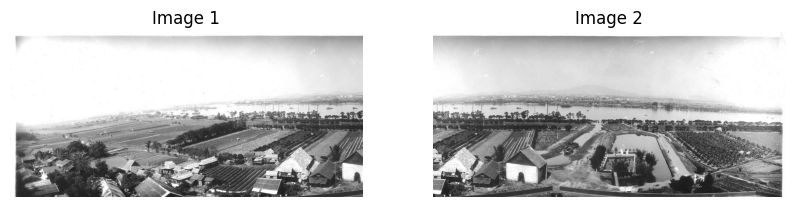

In [8]:
import cv2
import matplotlib.pyplot as plt


# Convert images from BGR to RGB (Matplotlib expects RGB format)
resized_image_rgb_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
resized_image_rgb_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

# Plot both images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and position 1
plt.imshow(resized_image_rgb_1)
plt.title('Image 1')
plt.axis('off')  # Turn off axis

# Plot the second image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and position 2
plt.imshow(resized_image_rgb_2)
plt.title('Image 2')
plt.axis('off')  # Turn off axis

plt.show()

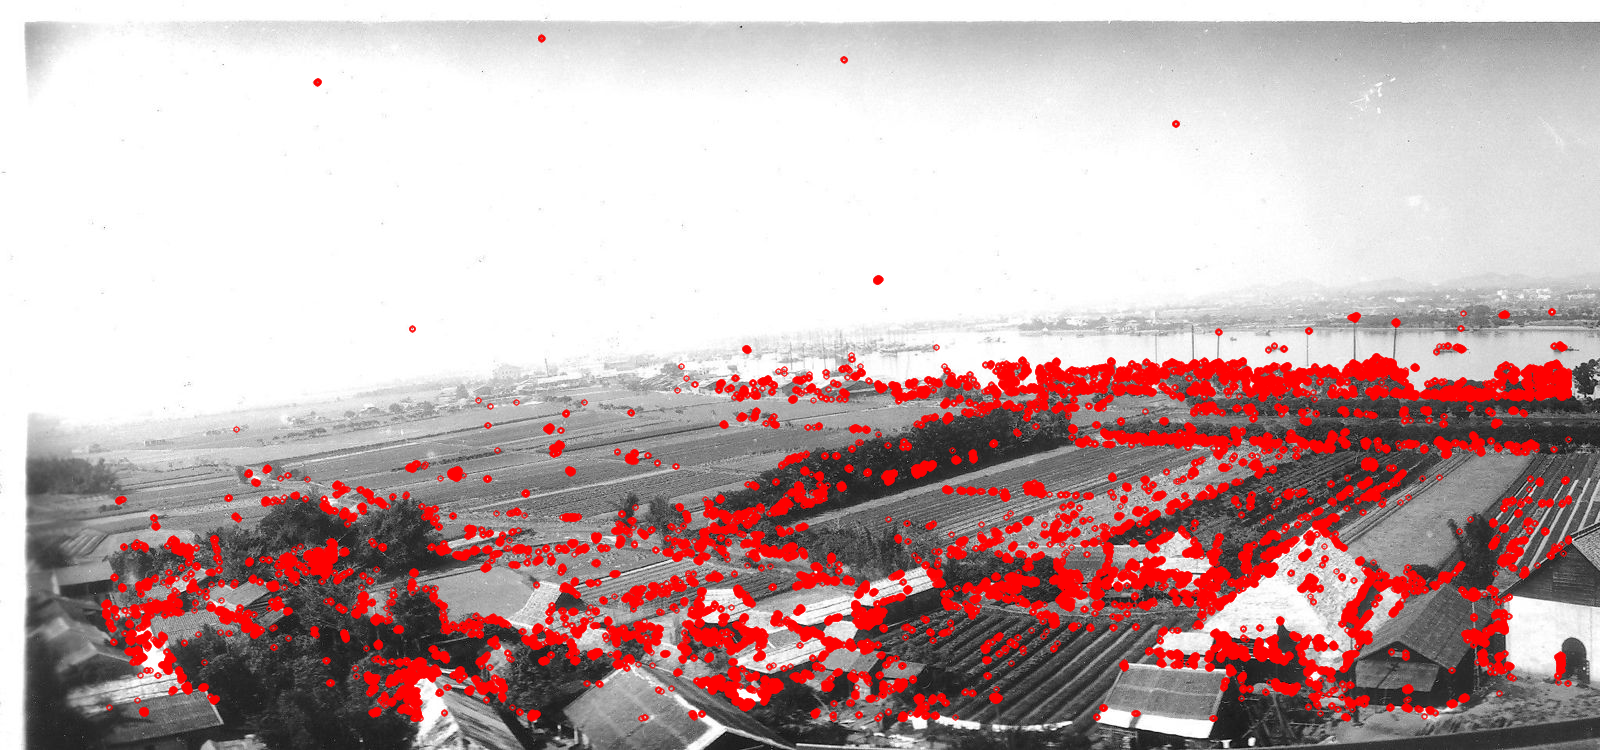

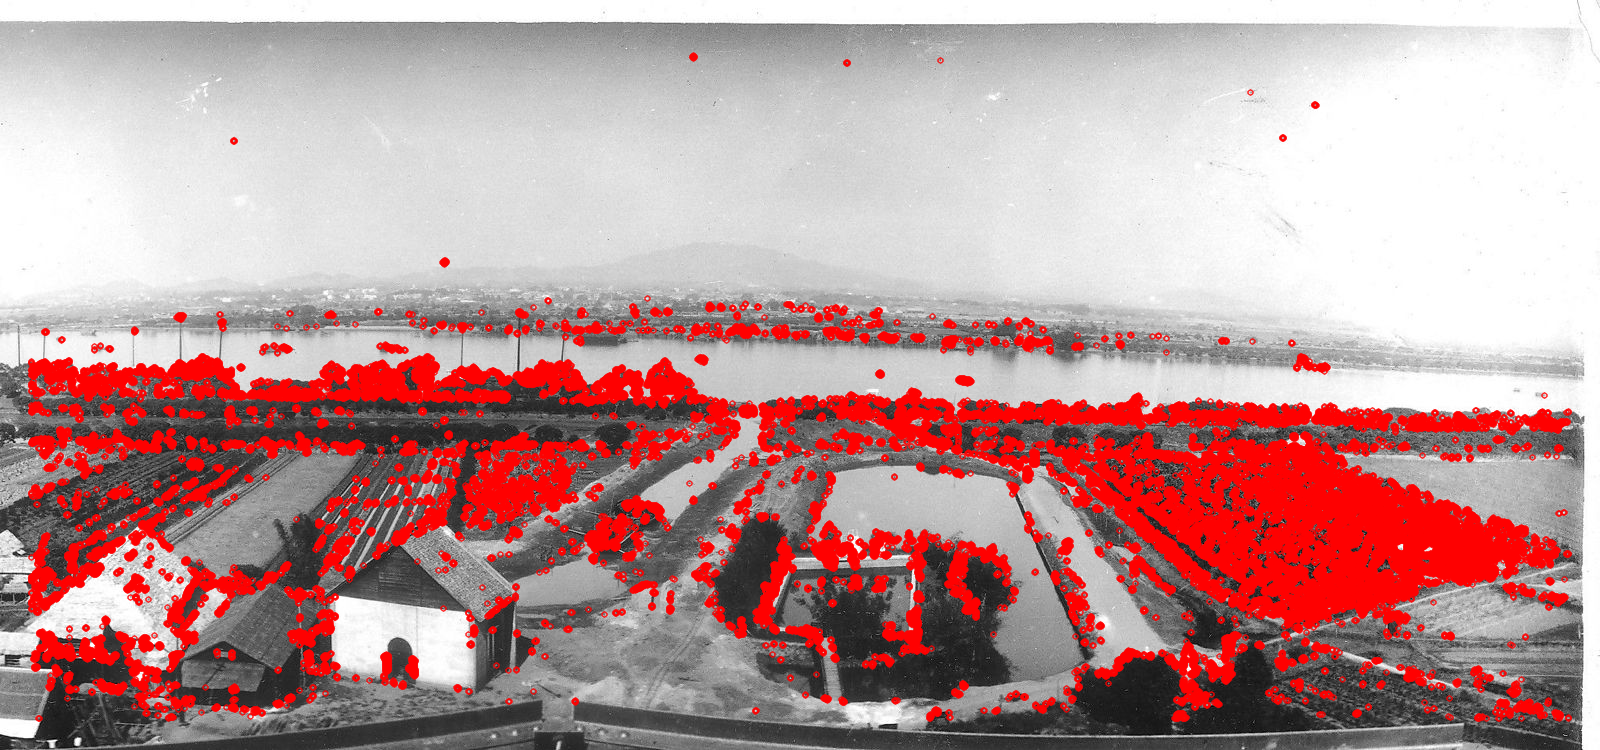

In [9]:
pano,non_blend,left_side,right_side, k1, k2, good_matches =ImageStitcher.warp_blend_and_crop_images(image_1, image_2, True)

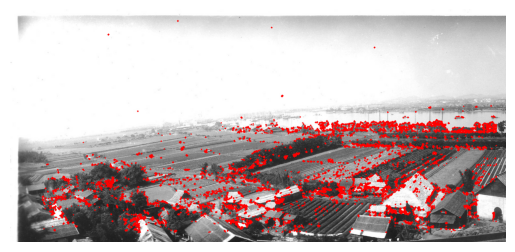

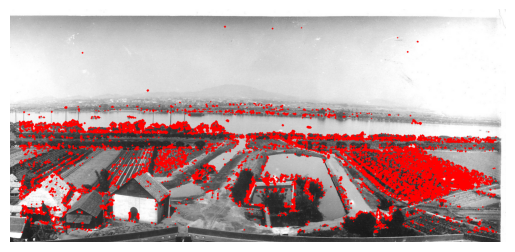

In [10]:
def plot_cv2_keypoints(image, keypoints):
    # Convert cv2.KeyPoint objects to a list of (i, j) coordinates
    keypoints_list = [(int(kp.pt[1]), int(kp.pt[0])) for kp in keypoints]

    # Draw keypoints on the image
    image_with_keypoints = image.copy()
    for i, j in keypoints_list:
        cv2.circle(image_with_keypoints, (j, i), 2, (255, 0, 0), -1)

    # Display the image with keypoints
    plt.imshow(image_with_keypoints)
    plt.axis('off')  # Turn off axis
    plt.show()

# Plot the keypoints on the image
plot_cv2_keypoints(image_1, k1)
plot_cv2_keypoints(image_2, k2)

In [11]:
def convert_result(img):
    img_normalized = np.array(img, dtype=float) / 255
    img_rgb = img_normalized[:, :, ::-1]
    return img_rgb

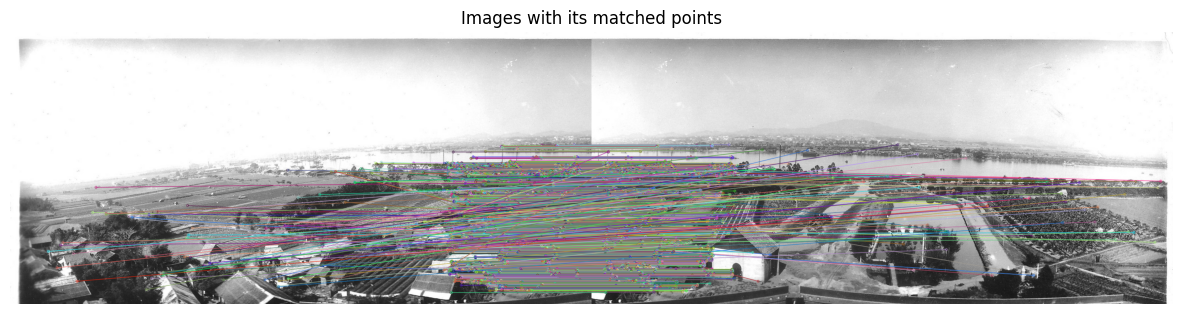

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_matches(image1, keypoints1, image2, keypoints2, matches):
    """Plot matches between keypoints in two images"""
    # Draw matches between the two images
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Convert BGR image to RGB for display
    matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

    # Display the matched image
    plt.figure(figsize=(15, 15))
    plt.imshow(matched_image_rgb)
    plt.title('Images with its matched points')
    plt.axis('off')
    plt.show()


plot_matches(image_1, k1, image_2, k2, good_matches)


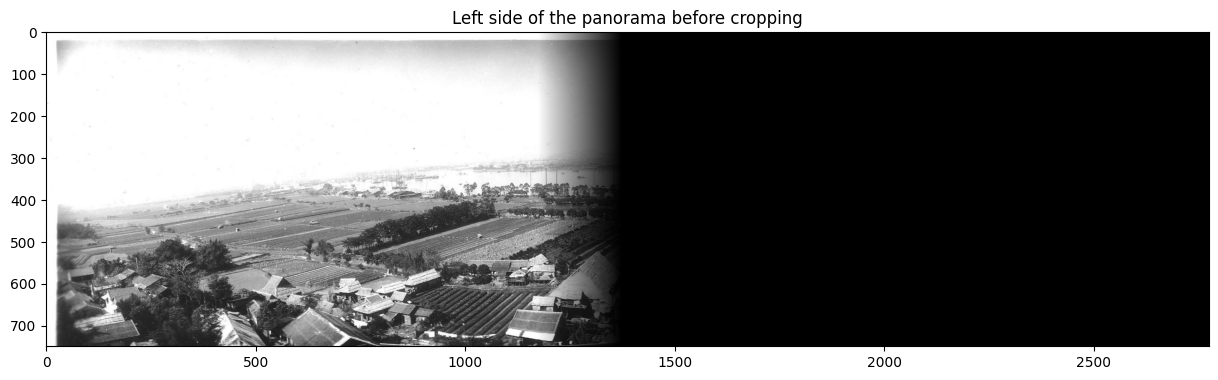

In [13]:
#display the leftside of pano before cropping
plt.figure(figsize=(15,15))
plt.title('Left side of the panorama before cropping')
plt.imshow(convert_result(left_side))

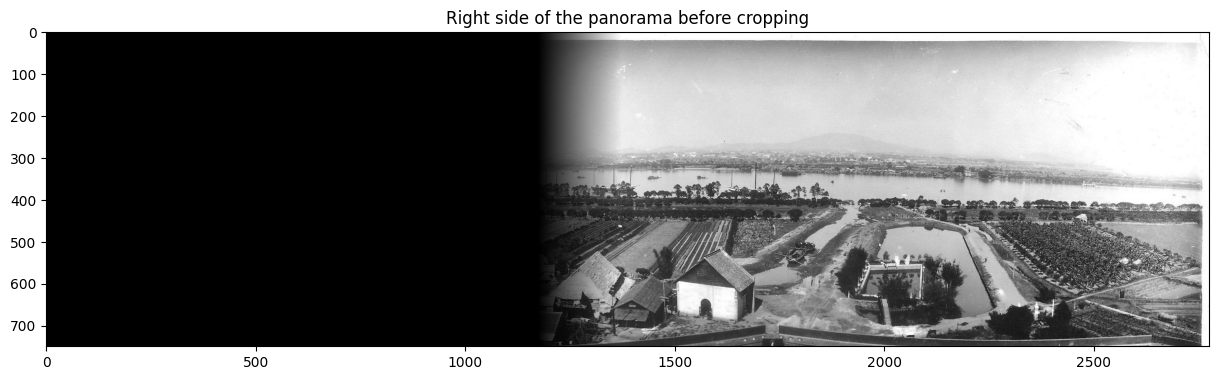

In [14]:
#display the rightside of pano before cropping
plt.figure(figsize=(15,15))
plt.title('Right side of the panorama before cropping')
plt.imshow(convert_result(right_side))

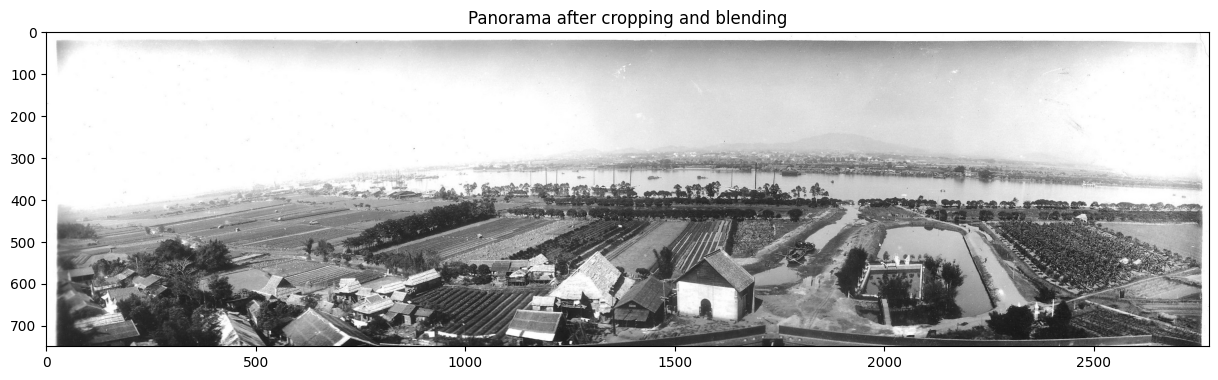

In [15]:
#pano after cropping and blending
plt.figure(figsize=(15,15))
plt.title('Panorama after cropping and blending')
plt.imshow(convert_result(pano))

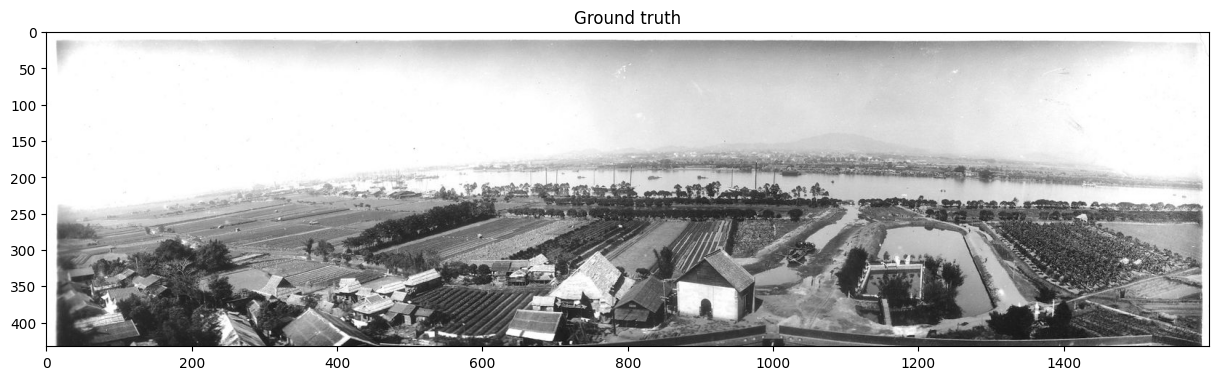

In [16]:
plt.figure(figsize=(15,15))
plt.title('Ground truth')
plt.imshow(pano_ori)

Accuracy Scores


In [17]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def image_similarity(image1, image2):
    """Calculate similarity between two images using Mean Squared Error (MSE) and Structural Similarity Index (SSI)"""
    # Convert images to appropriate depth (8-bit unsigned integers)
    image1 = cv2.convertScaleAbs(image1)
    image2 = cv2.convertScaleAbs(image2)

    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((gray_image1.astype(float) - gray_image2.astype(float)) ** 2)

    # Calculate Structural Similarity Index (SSI)
    ssi = ssim(gray_image1, gray_image2)

    return mse, ssi

In [18]:
pano.shape

(750, 2774, 3)

In [21]:
pano_ori = cv2.imread('GT.jpeg')

pano_ori.shape

(433, 1600, 3)

In [22]:
pano_ori_resized = cv2.resize(pano_ori, (pano.shape[1], pano.shape[0]))

In [23]:
pano_ori.shape

(433, 1600, 3)

In [24]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def image_similarity(image1, image2):
    """Calculate similarity between two images using Mean Squared Error (MSE) and Structural Similarity Index (SSI)"""
    # Convert images to appropriate depth (8-bit unsigned integers)
    image1 = cv2.convertScaleAbs(image1)
    image2 = cv2.convertScaleAbs(image2)

    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((gray_image1.astype(float) - gray_image2.astype(float)) ** 2)

    # Calculate Structural Similarity Index (SSI)
    ssi = ssim(gray_image1, gray_image2)

    return mse, ssi


In [25]:
image_similarity(pano, pano_ori_resized)

(146.38810189858208, 0.8262209849816149)